In [1]:
from mamba_mic.data_modules.brats2024 import BraTS2024DataModule

/home/eriksalv/workspace/mamba-mic/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_module = BraTS2024DataModule(batch_size=1)

data_module.prepare_data()
data_module.setup()

/home/eriksalv/workspace/mamba-mic/.venv/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [3]:
import shutil

In [4]:
data_module.test_set.data

In [5]:
data_module.test_set.data[0]["label"]

'./data/BRATS2024/training_data1_v2/BraTS-GLI-02809-101/BraTS-GLI-02809-101-seg.nii.gz'

In [6]:
for subject in data_module.test_set.data:
    shutil.copy(subject["label"], "./data/BRATS2024/gt")

In [7]:
import os

len(os.listdir("./data/BRATS2024/gt"))

135

In [8]:
len(os.listdir("./data/BRATS2024/scores"))

405

In [9]:
import pandas as pd

In [10]:
scores = [
    "./data/BRATS2024/scores/" + score_csv
    for score_csv in os.listdir("./data/BRATS2024/scores")
]

score_df = pd.DataFrame()
for score in scores:
    df = pd.read_csv(score)
    model, subject = score.split("/")[-1].split("_")
    df["model"] = model
    df["subject"] = subject.split(".")[0]
    score_df = pd.concat([score_df, df])

In [11]:
score_df.groupby(["model", "Labels"]).agg(
    {
        "LesionWise_Score_Dice": "mean",
        "LesionWise_Score_HD95": "mean",
        "Legacy_Dice": "mean",
    }
)

LesionWise_Score_Dice  LesionWise_Score_HD95  Legacy_Dice
model     Labels                                                           
segmamba  ET                   0.775330              34.950956     0.823766
          NETC                 0.715632              50.814498     0.683159
          RC                   0.704904              53.781111     0.732090
          SNFH                 0.720620              58.318402     0.871544
          TC                   0.785999              31.283649     0.832068
          WT                   0.712182              62.069860     0.883734
segresnet ET                   0.771851              38.703861     0.831518
          NETC                 0.713423              50.763048     0.680232
          RC                   0.750627              41.656050     0.767345
          SNFH                 0.748021              44.386019     0.869875
          TC                   0.780729              35.270722     0.835840
          WT                   0.746728              47.084898     0.883714
swinunetr ET                   0.788544              29.226220     0.837616
          NETC                 0.730527              48.497321     0.698996
          RC                   0.701689              52.208420     0.727647
          SNFH                 0.741092              49.675349     0.872173
          TC                   0.780579              36.591284     0.839895
          WT                   0.739331              51.577439     0.883654

In [39]:
score_df.groupby(["model"]).agg(
    {
        "LesionWise_Score_Dice": "mean",
        "LesionWise_Score_HD95": "mean",
        "Legacy_Dice": "mean",
    }
)

,LesionWise_Score_Dice,LesionWise_Score_HD95,Legacy_Dice
model,,,
segmamba,0.735778,48.536413,0.804393
segresnet,0.751896,42.977433,0.811421
swinunetr,0.746960,44.629339,0.809997


In [13]:
score_df.to_csv("./data/BRATS2024/all_scores.csv", index=False)

In [14]:
# Get mean dice across all labels for each subject and model
subject_scores = (
    score_df.groupby(["model", "subject"]).agg({"Legacy_Dice": "mean"}).reset_index()
)

# For each model, find subjects with min, median and max dice scores
for model in subject_scores["model"].unique():
    model_scores = subject_scores[subject_scores["model"] == model]

    min_subject = model_scores.loc[model_scores["Legacy_Dice"].idxmin()]
    max_subject = model_scores.loc[model_scores["Legacy_Dice"].idxmax()]

    # Get median subject
    median_idx = len(model_scores) // 2
    median_subject = model_scores.sort_values("Legacy_Dice").iloc[median_idx]

    print(f"\n{model}:")
    print(f"Min dice ({min_subject['Legacy_Dice']:.3f}): {min_subject['subject']}")
    print(
        f"Median dice ({median_subject['Legacy_Dice']:.3f}): {median_subject['subject']}"
    )
    print(f"Max dice ({max_subject['Legacy_Dice']:.3f}): {max_subject['subject']}")


segmamba:
Min dice (0.433): BraTS-GLI-02982-100
Median dice (0.803): BraTS-GLI-02204-103
Max dice (0.984): BraTS-GLI-02736-100

segresnet:
Min dice (0.439): BraTS-GLI-02982-100
Median dice (0.823): BraTS-GLI-02194-105
Max dice (0.980): BraTS-GLI-02092-104

swinunetr:
Min dice (0.425): BraTS-GLI-03049-100
Median dice (0.810): BraTS-GLI-02204-103
Max dice (0.983): BraTS-GLI-02092-103


In [15]:
score_df.query("subject == 'BraTS-GLI-02194-105'")

,Labels,Num_TP,Num_FP,Num_FN,Sensitivity,Specificity,Legacy_Dice,Legacy_HD95,GT_Complete_Volume,LesionWise_Score_Dice,LesionWise_Score_HD95,model,subject
0,WT,1.0,0.0,0.0,0.923192,0.999786,0.950105,1.000000,75864.0,0.950105,1.000000,segresnet,BraTS-GLI-02194-105
1,TC,1.0,0.0,0.0,0.663533,0.999981,0.786859,2.236068,5956.0,0.786859,2.236068,segresnet,BraTS-GLI-02194-105
2,NETC,1.0,0.0,0.0,0.519126,0.999980,0.582822,16.155494,549.0,0.582822,16.155494,segresnet,BraTS-GLI-02194-105
3,SNFH,1.0,0.0,0.0,0.924672,0.999604,0.941034,1.000000,69908.0,0.941034,1.000000,segresnet,BraTS-GLI-02194-105
4,ET,1.0,0.0,0.0,0.646199,0.999977,0.770707,2.000000,5407.0,0.770707,2.000000,segresnet,BraTS-GLI-02194-105
5,RC,1.0,0.0,0.0,0.911497,0.999719,0.909116,3.000000,21570.0,0.909116,3.000000,segresnet,BraTS-GLI-02194-105
0,WT,1.0,0.0,0.0,0.944875,0.999563,0.951497,1.000000,75864.0,0.951497,1.000000,segmamba,BraTS-GLI-02194-105
1,TC,1.0,0.0,0.0,0.760913,0.999914,0.815695,3.316625,5956.0,0.815695,3.316625,segmamba,BraTS-GLI-02194-105
2,NETC,1.0,0.0,0.0,0.180328,0.999935,0.176786,18.439089,549.0,0.176786,18.439089,segmamba,BraTS-GLI-02194-105
3,SNFH,1.0,0.0,0.0,0.938491,0.999434,0.940212,1.414214,69908.0,0.940212,1.414214,segmamba,BraTS-GLI-02194-105


In [16]:
val_dice = pd.read_csv("val_dice.csv")
val_hd95 = pd.read_csv("val_hd95.csv")

In [17]:
import matplotlib.pyplot as plt
import numpy as np

In [18]:
epochs = np.arange(4, 500, 5)

In [32]:
segmamba_val_dice = pd.concat(
    [
        val_dice["SegMamba - val_dice"].dropna()[:24],
        val_dice["SegMamba-2 - val_dice"].dropna()[1:],
    ]
)
segmamba_val_hd95 = pd.concat(
    [
        val_hd95["SegMamba - val_hd95"].dropna()[:24],
        val_hd95["SegMamba-2 - val_hd95"].dropna()[1:],
    ]
)

segresnet_val_dice = pd.concat(
    [
        val_dice["SegResNet-1 - val_dice"].dropna(),
        val_dice["SegResNet-2 - val_dice"].dropna()[1:],
    ]
)
segresnet_val_hd95 = pd.concat(
    [
        val_hd95["SegResNet-1 - val_hd95"].dropna(),
        val_hd95["SegResNet-2 - val_hd95"].dropna()[1:],
    ]
)

swin_val_dice = pd.concat(
    [
        val_dice["SwinUNETR-1 - val_dice"].dropna(),
        val_dice["SwinUNETR-2 - val_dice"].dropna()[1:],
    ]
)
swin_val_hd95 = pd.concat(
    [
        val_hd95["SwinUNETR-1 - val_hd95"].dropna(),
        val_hd95["SwinUNETR-2 - val_hd95"].dropna()[1:],
    ]
)

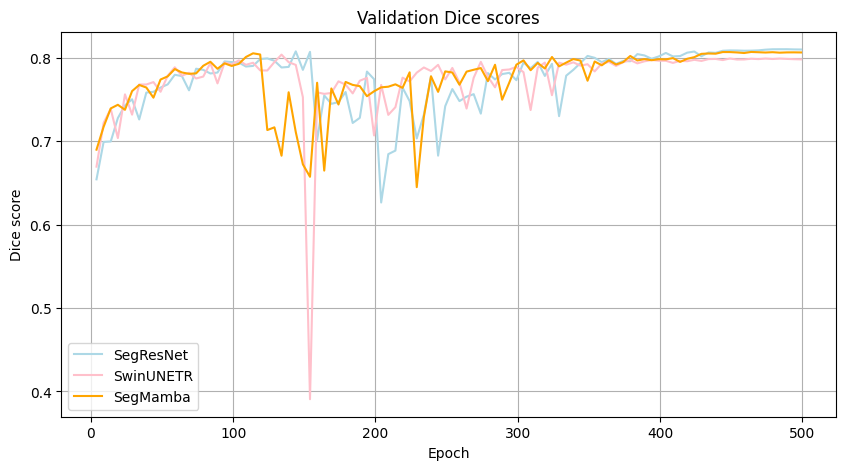

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, segresnet_val_dice, c="lightblue")
plt.plot(epochs, swin_val_dice, c="pink")
plt.plot(epochs, segmamba_val_dice, c="orange")
plt.grid()
plt.legend(["SegResNet", "SwinUNETR", "SegMamba"])
plt.title("Validation Dice scores")
plt.xlabel("Epoch")
plt.ylabel("Dice score")
plt.savefig("val_dice.png")

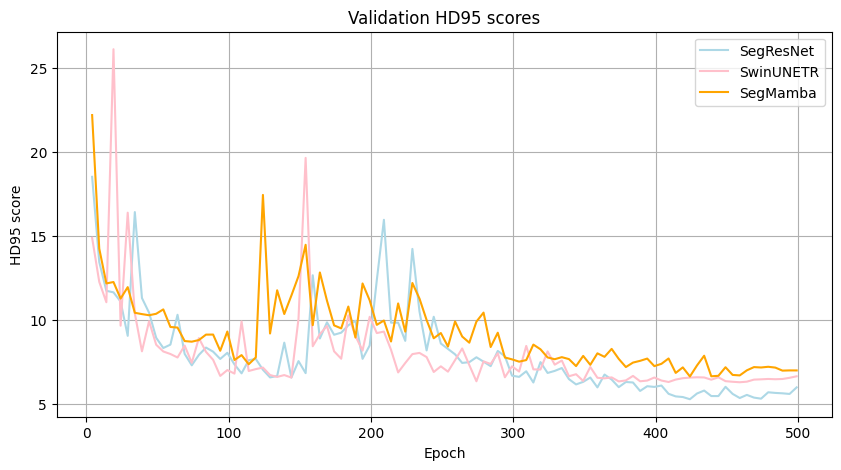

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, segresnet_val_hd95, c="lightblue")
plt.plot(epochs, swin_val_hd95, c="pink")
plt.plot(epochs, segmamba_val_hd95, c="orange")
plt.grid()
plt.legend(["SegResNet", "SwinUNETR", "SegMamba"])
plt.title("Validation HD95 scores")
plt.xlabel("Epoch")
plt.ylabel("HD95 score")
plt.savefig("val_hd95.png")